# NBA Most Valorated Player Analysis

## Loading Data

In [96]:
# Setup
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import seaborn as sns
from IPython.display import display_markdown

sns.set()
warnings.filterwarnings("ignore")
data_path = Path("data")
main_data_path = data_path / "full_data.csv"

- votaciones: https://www.basketball-reference.com/awards/awards_1989.html#all_nba_mvp

In [97]:
path_mvp = data_path / "mvp"

years = (1980, 2026)

df_raw = pd.DataFrame(
    columns=[
        "Rank",
        "Player",
        "Age",
        "Tm",
        "First",
        "Pts Won",
        "Pts Max",
        "Share",
        "G",
        "MP",
        "PTS",
        "TRB",
        "AST",
        "STL",
        "BLK",
        "FG%",
        "3P%",
        "FT%",
        "WS",
        "WS/48",
        "Year",
    ],
    dtype="object",
)

for year in range(*years):
    df_y = pd.read_csv(path_mvp / f"mvp_{year}.csv")
    df_raw = pd.concat([df_raw, df_y])
df_raw

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,...,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,...,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,...,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,...,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,...,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,LeBron James,40,LAL,0.0,16.0,1000,0.016,70,34.9,...,7.8,8.2,1.0,0.6,0.513,0.376,0.782,7.7,0.152,2025
6,7,Cade Cunningham,23,DET,0.0,12.0,1000,0.012,70,35.0,...,6.1,9.1,1.0,0.8,0.469,0.356,0.846,5.9,0.115,2025
7,8,Anthony Edwards,23,MIN,0.0,12.0,1000,0.012,79,36.3,...,5.7,4.5,1.2,0.6,0.447,0.395,0.837,8.4,0.140,2025
8,9,Stephen Curry,36,GSW,0.0,2.0,1000,0.002,70,32.2,...,4.4,6.0,1.1,0.4,0.448,0.397,0.933,7.9,0.168,2025


In [98]:
path_teams = data_path / "season"
cols = ["Team", "WinRatio", "PPG", "PAG", "Conference", "Rank", "Year"]
df_raw_t = pd.DataFrame(columns=cols)

for year in range(*years):
    df_y = pd.read_csv(path_teams / f"season_{year}.csv")
    df_raw_t = pd.concat([df_raw_t, df_y])
df_raw_t

,Team,WinRatio,PPG,PAG,Conference,Rank,Year
0,BOS,0.744,113.5,105.7,East,1,1980
1,PHI,0.720,109.1,104.9,East,2,1980
2,WSB,0.476,107.0,109.5,East,3,1980
3,NYK,0.476,114.0,115.1,East,4,1980
4,NJN,0.415,108.3,109.5,East,5,1980
...,...,...,...,...,...,...,...
25,PHO,0.439,113.6,116.6,West,11,2025
26,POR,0.439,110.9,113.9,West,12,2025
27,SAS,0.415,113.9,116.7,West,13,2025
28,NOP,0.256,109.8,119.3,West,14,2025


## Preprocessing 

- Drop columns `First, Pts Won, Pts Max, WS`, since they are reiterative and lack information.
- Transform several columns to `int` type.
- Rename several columns
- Several players (looking at you **Shaq**) have 0/0 3FG, which are registered as _missing values_ at source.
- Rename for `Nikola Jokic`, `Peja Sojakovic` and `Luca Doncic` to avoid troubles with encoding.

In [99]:
df_p = df_raw.reset_index(drop=True).drop(
    columns=["First", "Pts Won", "Pts Max", "WS"]
)
df_p["Player"] = df_p["Player"].replace(
    {
        "Nikola JokiÄ\x87": "Nikola Jokic",
        "Luka DonÄ\x8diÄ\x87": "Luka Doncic",
        "Peja StojakoviÄ\x87": "Peja Stojakovic",
    }
)
df_p["Age"] = df_p["Age"].astype(int)
df_p["Year"] = df_p["Year"].astype(int)
df_p["Rank"] = df_p["Rank"].apply(
    lambda x: int(x[:-1]) if str(x).endswith("T") else int(x)
)
df_p["G"] = df_p["G"].astype(int)
df_p = df_p.rename(
    columns={
        "G": "Games",
        "Tm": "Team",
        "TRB": "Rebs",
    }
)
df_p["3P%"] = df_p["3P%"].fillna(0)
nas = len(df_p[df_p.isna().any(axis=1)])
print(f"Total NA in players dataframe: {nas}")

Total NA in players dataframe: 0


#### Adding Team Stats

- Missing teams: mark as `TOT` since it indicates the player payed for several teams that season. Missing values are expected. We may delete these rows if they give problems.
- Join teams

In [100]:
df_t = df_raw_t.copy()
df_t["Team"] = df_t["Team"].fillna("TOT")
df_prev = pd.merge(
    df_p,
    df_t,
    how="left",
    left_on=["Year", "Team"],
    right_on=["Year", "Team"],
    suffixes=[None, "_T"],
)
df_prev[df_prev.isna().any(axis=1)]
df_prev = df_prev.dropna()
df_prev.to_csv(main_data_path, index=False)

In [101]:
del df_raw, df_raw_t

## Exploratory Data Analysis

### MVP winners per Age

Saved full df into data/full_data.csv


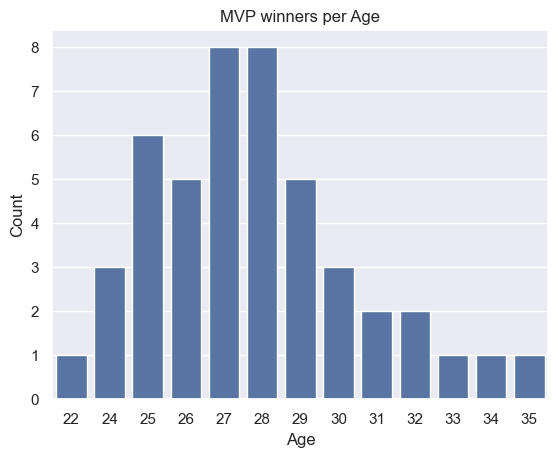

- Youngest player to win NBA MVP: Derrick Rose at 22 years old.

- Oldest player to win NBA MVP:   Karl Malone at 35 years old.

In [102]:
df_prev = pd.read_csv(main_data_path)
print(f"Saved full df into {main_data_path}")
dfwin: pd.DataFrame = df_prev[df_prev["Rank"] == 1].copy()
sns.countplot(dfwin, x="Age")
plt.title("MVP winners per Age")
plt.ylabel("Count")
plt.show()
youngest = df_p.iloc[df_p[df_p["Rank"] == 1]["Age"].idxmin()]  # type: ignore
oldest = df_p.iloc[df_p[df_p["Rank"] == 1]["Age"].idxmax()]  # type: ignore
display_markdown(
    f"- Youngest player to win NBA MVP: {youngest['Player']} at {youngest['Age']} years old.",
    raw=True,
)
display_markdown(
    f"- Oldest player to win NBA MVP:   {oldest['Player']} at {oldest['Age']} years old.",
    raw=True,
)

### MVP winners per Team

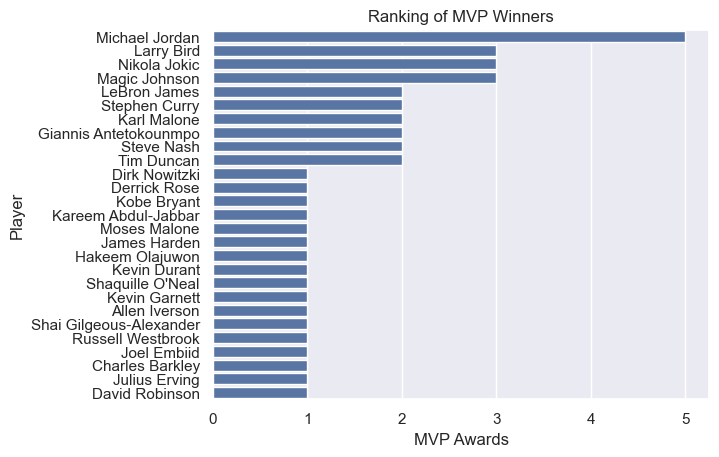

In [103]:
sns.barplot(
    dfwin.groupby(["Team", "Player"])
    .count()
    .sort_values("Year", ascending=False),
    y="Player",
    x="Year",
)
plt.title("Ranking of MVP Winners")
plt.xlabel("MVP Awards")
plt.show()

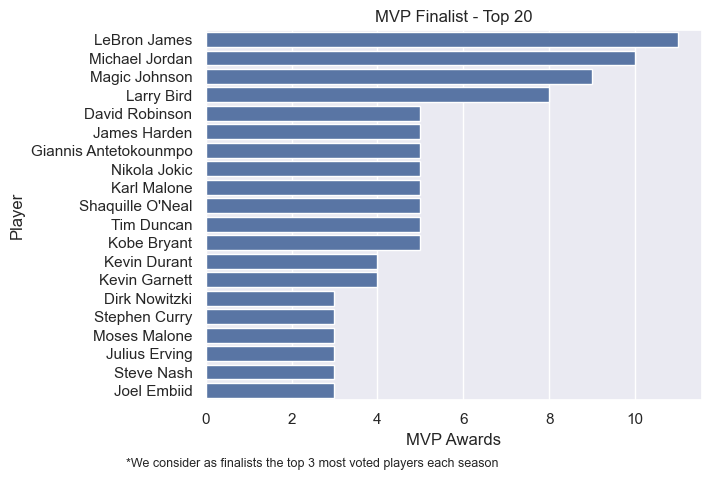

In [104]:
df_fin = df_prev.copy()[df_prev["Rank"] <= 3]
sns.barplot(
    df_fin.groupby("Player")
    .count()
    .sort_values("Year", ascending=False)
    .nlargest(20, "Year"),
    y="Player",
    x="Year",
)
plt.title("MVP Finalist - Top 20")
plt.figtext(
    0,
    -0.03,
    "*We consider as finalists the top 3 most voted players each season",
    ha="left",
    fontsize=9,
)
plt.xlabel("MVP Awards")
plt.show()

In [105]:
df_wr = pd.DataFrame(
    df_fin.groupby("Player")
    .count()
    .sort_values("Year", ascending=False)["Year"]
)
df_wr = df_wr.rename(columns={"Year": "Nominations"})
df_wr["Wins"] = (
    dfwin.groupby("Player").count().sort_values("Year", ascending=False)["Year"]
)
df_wr["Wins"] = df_wr["Wins"].fillna(0).astype(int)
df_wr["WR"] = df_wr["Wins"] / df_wr["Nominations"]
df_wr["WR"] = df_wr["WR"].apply(lambda x: x * 100)
df_wr = df_wr.sort_values("WR", ascending=False)

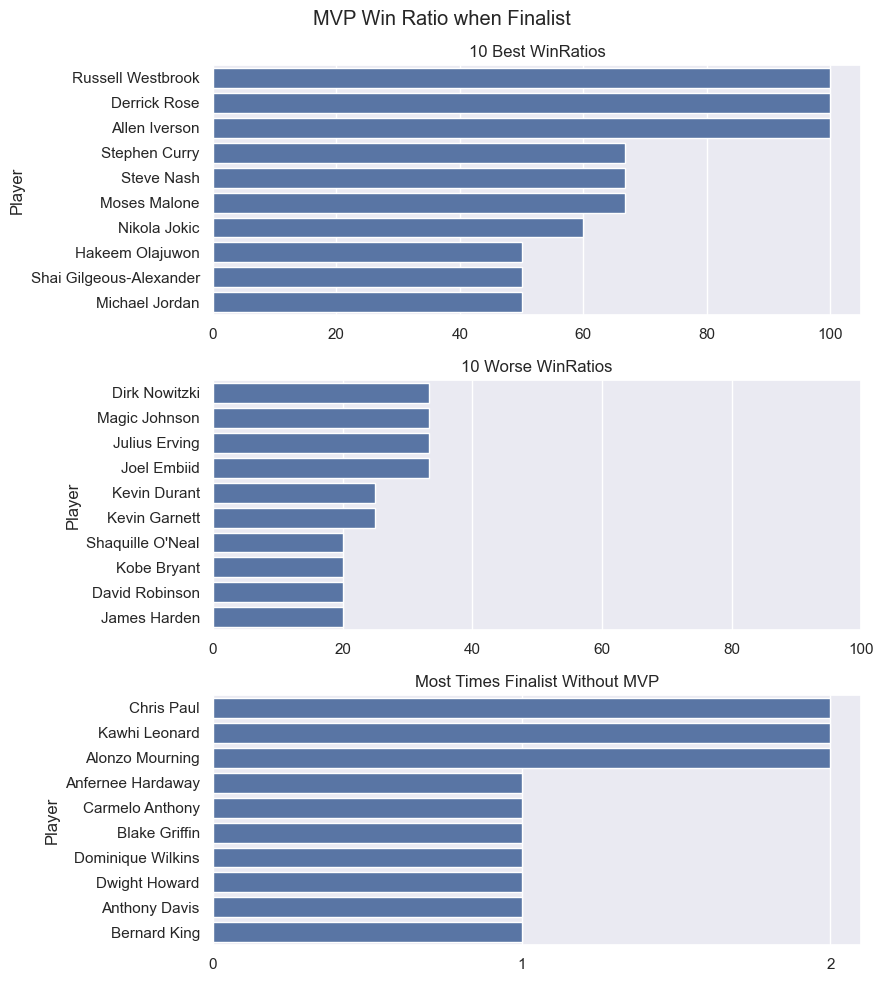

In [106]:
fig, ax = plt.subplots(3, 1, figsize=(9, 10))
sns.barplot(
    df_wr[df_wr["WR"] > 0].nlargest(10, "WR"),
    x="WR",
    y="Player",
    ax=ax[0],
)
ax[0].set_title("10 Best WinRatios")
sns.barplot(
    df_wr[df_wr["WR"] > 0]
    .nsmallest(10, "WR")
    .sort_values("WR", ascending=False),
    x="WR",
    y="Player",
    ax=ax[1],
)
ax[1].set_title("10 Worse WinRatios")
ax[1].set_xlim(0, 100)
sns.barplot(
    df_wr[df_wr["WR"] == 0]
    .nlargest(10, "Nominations")
    .sort_values("Nominations", ascending=False),
    x="Nominations",
    y="Player",
    ax=ax[2],
)
ax[2].set_title("Most Times Finalist Without MVP")
ax[2].set_xticks([0, 1, 2])
[a.set_xlabel(None) for a in ax]
fig.suptitle(
    "MVP Win Ratio when Finalist",
)
fig.tight_layout()
plt.show()

### Hand to Hand Comparison

Let's now compare the statistics of both players, Nikola Jokić and Shai Gilgeous-Alexander, considering both individual and team metrics.

All statistics have been normalized, and values representing negative performance have been inverted accordingly. <br>
In short:
- An upward trend indicates better performance
- A downward trend indicates worse performance

Normalization using Z-score $\left(z = \cfrac{x - \mu}{\sigma}\right)$ over the range of values. Origin is stablished at the mean of the previous MVP winner stats (2024 and previous). <br>
Remember:

- $Z-score \in [-1, 1] \supset 65\%$ of values
- $Z-score \in [-2, 2] \supset 95\%$ of values

> Since $n > 30$ we asume normality in our data

In [107]:
negative_cols = ["Rank_T", "PAG"]


def reverse_stat(x: pd.Series):
    if x["Stat"] in negative_cols:
        x["Rest"] = -x["Rest"]
        x["Shai"] = -x["Shai"]
        x["Jokic"] = -x["Jokic"]
    return x


drop_cols = ["Year", "Player", "Rank", "Team", "Conference"]
df_rest_std = dfwin[dfwin["Year"] < 2025].drop(columns=drop_cols).std()
df_rest = dfwin[dfwin["Year"] < 2025].drop(columns=drop_cols).mean()
df_rest["Player"] = "Rest"
df_shai = df_prev[df_prev["Year"] == 2025].iloc[0]
df_jokic = df_prev[df_prev["Year"] == 2025].iloc[1]

df_comp = pd.concat([df_rest, df_rest_std, df_shai, df_jokic], axis=1).drop(
    drop_cols
)
df_comp.columns = ["Rest", "std", "Shai", "Jokic"]
df_comp = df_comp.reset_index().rename(columns={"index": "Stat"})
df_comp = df_comp.apply(reverse_stat, axis=1)

df_comp_melt = (
    df_comp.set_index("Stat")
    .apply(lambda x: (x - x["Rest"]) / x["std"], axis=1)
    .reset_index()
).drop(columns=["Rest", "std"])
df_comp_melt = df_comp_melt.melt(
    id_vars="Stat", var_name="Player", value_name="Value"
)

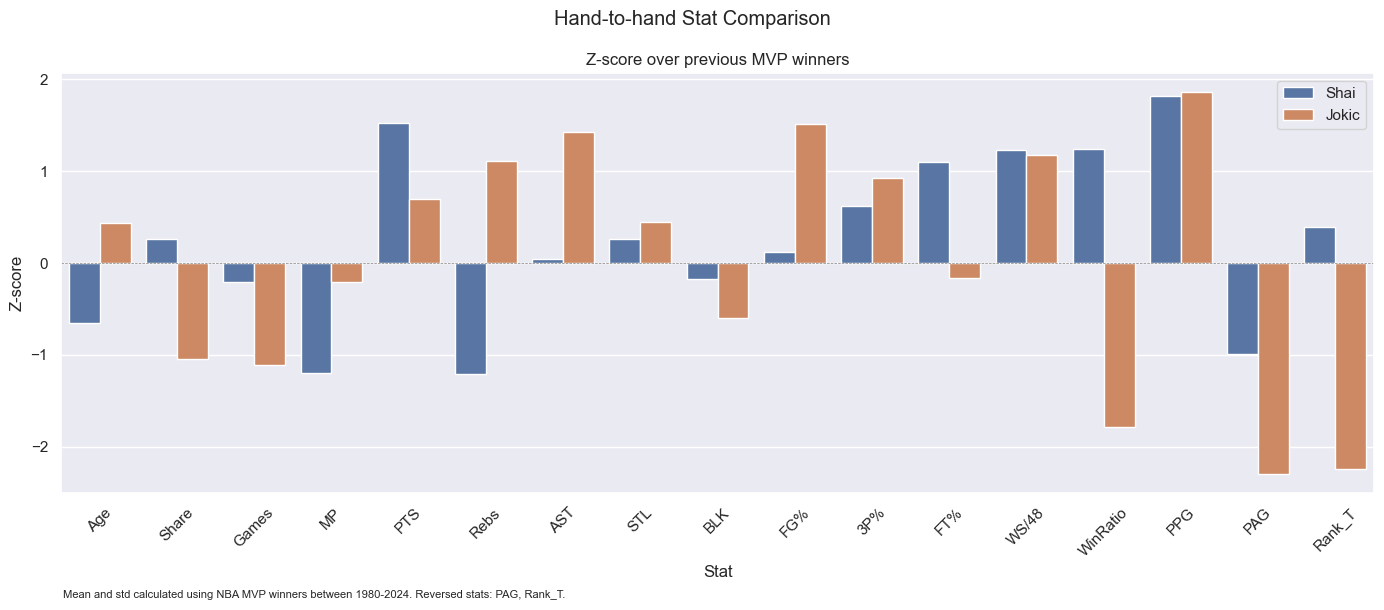

In [108]:
fig, _ = plt.subplots(figsize=(14, 6))
ax = sns.barplot(
    df_comp_melt,
    x="Stat",
    y="Value",
    hue="Player",
)
ax.get_legend().set_title("")
plt.suptitle("Hand-to-hand Stat Comparison")
plt.title("Z-score over previous MVP winners")
plt.xticks(rotation=45, ha="center")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
plt.ylabel("Z-score")
plt.figtext(
    0.23,
    0,
    "Mean and std calculated using NBA MVP winners between 1980-2024. Reversed stats: PAG, Rank_T.",
    fontsize=8,
    ha="center",
)
plt.tight_layout()
plt.show()

### MVP Team Stats

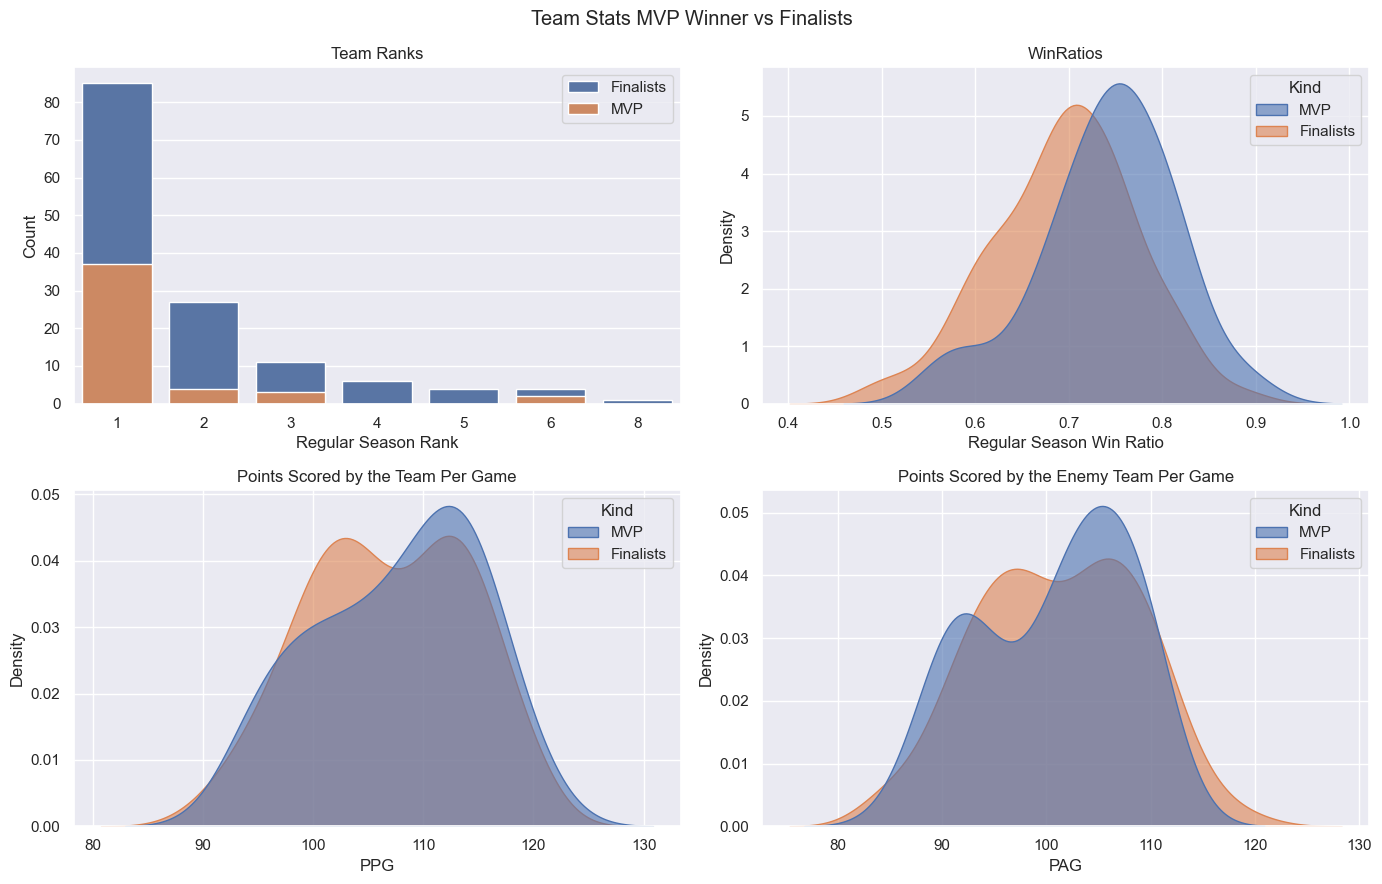

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(14, 9))
sns.countplot(df_fin, x="Rank_T", ax=ax[0, 0], alpha=1, label="Finalists")
sns.countplot(dfwin, x="Rank_T", ax=ax[0, 0], alpha=1, label="MVP")
ax[0, 0].set_title("Team Ranks")
ax[0, 0].set_xlabel("Regular Season Rank")
ax[0, 0].set_ylabel("Count")
ax[0, 0].legend()

df_wr_win = dfwin[["WinRatio", "PPG", "PAG"]]
df_wr_win["Kind"] = "MVP"
df_wr_fin = pd.DataFrame(df_fin[["WinRatio", "PPG", "PAG"]])
df_wr_fin["Kind"] = "Finalists"
df_dist_wr = pd.concat([df_wr_win, df_wr_fin])
sns.kdeplot(
    df_dist_wr,
    x="WinRatio",
    hue="Kind",
    alpha=0.6,
    common_norm=False,
    fill=True,
    ax=ax[0, 1],
)
ax[0, 1].set_title("WinRatios")
ax[0, 1].set_xlabel("Regular Season Win Ratio")

sns.kdeplot(
    df_dist_wr,
    x="PPG",
    hue="Kind",
    alpha=0.6,
    common_norm=False,
    fill=True,
    ax=ax[1, 0],
)
ax[1, 0].set_title("Points Scored by the Team Per Game")
ax[1, 0].set_xlabel("PPG")
sns.kdeplot(
    df_dist_wr,
    x="PAG",
    hue="Kind",
    alpha=0.6,
    common_norm=False,
    fill=True,
    ax=ax[1, 1],
)
ax[1, 1].set_title("Points Scored by the Enemy Team Per Game")
ax[1, 1].set_xlabel("PAG")
fig.suptitle("Team Stats MVP Winner vs Finalists")
fig.tight_layout()
plt.show()

In [110]:
df_dist_wr

,WinRatio,PPG,PAG,Kind
0,0.732,115.1,109.2,MVP
9,0.756,111.7,103.8,MVP
19,0.561,105.9,105.9,MVP
29,0.793,112.1,104.4,MVP
39,0.756,112.1,105.6,MVP
...,...,...,...,...
438,0.695,120.1,112.7,Finalists
439,0.610,117.9,115.6,Finalists
446,0.829,120.5,107.6,Finalists
447,0.610,120.8,116.9,Finalists


In [111]:
df_g = df_prev.copy()
df_g["Group"] = "All"
df_g = pd.concat([df_g, df_prev[df_prev["Rank"] <= 3]])
df_g["Group"] = df_g["Group"].fillna("Finalist")
df_g = pd.concat([df_g, df_prev[df_prev["Rank"] == 1]])
df_g["Group"] = df_g["Group"].fillna("MVP")
df_g

,Rank,Player,Age,Team,Share,Games,MP,PTS,Rebs,AST,...,3P%,FT%,WS/48,Year,WinRatio,PPG,PAG,Conference,Rank_T,Group
0,1,Kareem Abdul-Jabbar,32,LAL,0.665,82,38.3,24.8,10.8,4.5,...,0.000,0.765,0.227,1980,0.732,115.1,109.2,West,1,All
1,2,Julius Erving,29,PHI,0.143,78,36.1,26.9,7.4,4.6,...,0.200,0.787,0.213,1980,0.720,109.1,104.9,East,2,All
2,3,George Gervin,27,SAS,0.086,78,37.6,33.1,5.2,2.6,...,0.314,0.852,0.173,1980,0.500,119.4,119.7,East,3,All
3,4,Larry Bird,23,BOS,0.068,82,36.0,21.3,10.4,4.5,...,0.406,0.836,0.182,1980,0.744,113.5,105.7,East,1,All
4,5,Tiny Archibald,31,BOS,0.009,80,35.8,14.1,2.5,8.4,...,0.222,0.830,0.148,1980,0.744,113.5,105.7,East,1,All
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1,Nikola Jokic,25,DEN,0.961,72,34.6,26.4,10.8,8.3,...,0.388,0.868,0.301,2021,0.653,115.1,110.1,West,3,MVP
417,1,Nikola Jokic,26,DEN,0.875,74,33.5,27.1,13.8,7.9,...,0.337,0.810,0.296,2022,0.585,112.7,110.4,West,6,MVP
427,1,Joel Embiid,28,PHI,0.915,66,34.6,33.1,10.2,4.2,...,0.330,0.857,0.259,2023,0.659,115.2,110.9,East,3,MVP
437,1,Nikola Jokic,28,DEN,0.935,79,34.6,26.4,12.4,9.0,...,0.359,0.817,0.299,2024,0.695,114.9,109.6,West,2,MVP


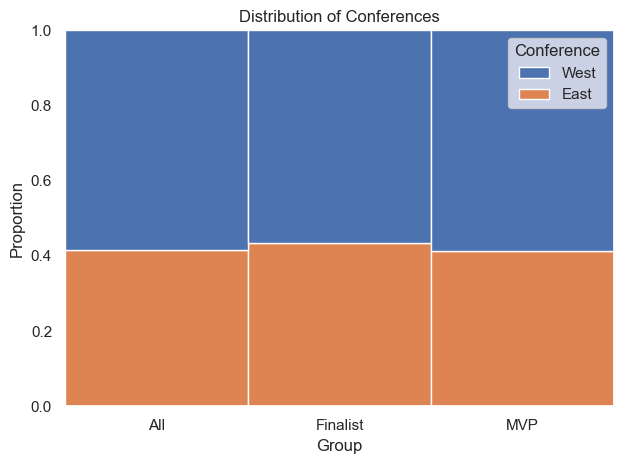

In [112]:
f, ax = plt.subplots()
sns.histplot(
    df_g,
    x="Group",
    hue="Conference",
    alpha=1,
    ax=ax,
    multiple="fill",
    common_norm=False,
)
ax.set_title("Distribution of Conferences")
ax.set_ylabel("Proportion")
f.tight_layout()
plt.show()

## Predictive Modeling

### Data Preparation

We are going to predict the Share of MVP votes for a player based on their individual and team statistics. The target variable is the `Share` column, which represents the percentage of total votes received by the player.

In order to prepare the data for modeling, we will:
- Normalize `Share` to a range of 0 to 1 on each season.
- Drop the `Share` column from the features.
- Drop the `Rank` column, as it would introduce information leakage.
- Drop the `Player` column, as it should not introduce statistical information.
- Drop the `Team` column, as it should not introduce statistical information.
- Drop the `WS/48` column, as it is highly correlated with the resto of the features and could introduce multicollinearity.
- Drop the data from the season 2024-2025, as we want to predict the MVP the votes for this season, since we want to know if Shai Gilgeous-Alexander is the predicted MVP, and this would introduce information leakage.

### Model Architecture

In order to capture the context of the MVP votes, where a player is compared to others in the same season, we will:
- Use a classification model to predict a player's scalar score $s_i$ for each player.
- For each year, apply a **softmax** for the predictions and compare to the actual share of votes received by the player:

$$\hat{p}_i = \frac{e^{s_i}}{\sum_j e^{s_j}}$$

- Use a **cross-entropy loss** or **KL divergence** to measure the difference between the predicted and actual distributions.

In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


df = pd.read_csv(main_data_path)
df_2025 = df[df["Year"] == 2025].copy()
df_prev = df[df["Year"] < 2025].copy()
seed = 420 # For reproducibility
drop_cols = ["Rank", "Player", "Team", "WS/48"]

def preprocess_df(df: pd.DataFrame, drop_cols: list[str]) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    df = df.copy()
    df["Share"] = df.groupby("Year")["Share"].transform(lambda x: x / x.sum())
    X = df.drop(columns=drop_cols).copy()
    X = X.drop(columns=["Share", "Year"])
    y = df["Share"]
    groups = df["Year"]
    return X, y, groups

X_train, y_train, groups = preprocess_df(df_prev, drop_cols=drop_cols)

preprocessor = ColumnTransformer([
    ("prep", StandardScaler(), X_train.select_dtypes("number").columns),
    ("cat", OneHotEncoder(drop='first'), ["Conference"])
])

model = Pipeline([
    ("prep", preprocessor),
    ("regressor", RandomForestRegressor(random_state=seed))
])

We will use a Grouped K-Fold Cross-Validation to ensure that the model is robust and generalizes well across different seasons. This will help us avoid overfitting to a specific season's data and train using the relatively small dataset of MVP votes.

In [131]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold


gfk = GroupKFold(n_splits=10, shuffle=True, random_state=seed) # type: ignore

mse = []
for train_index, test_index in gfk.split(X_train, y_train, groups):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    year_test = groups.iloc[test_index].unique()[:]
    print(f"Training on years {year_test}")
    
    model.fit(X_train_fold, y_train_fold)
    df_test = df_prev.iloc[test_index].copy()
    df_test["score"] = model.predict(X_test_fold)
    df_test["predicted_share"] = df_test.groupby("Year")["score"].transform(lambda x: x / x.sum())
    
    mse_by_year = df_test.groupby("Year").apply(
        lambda x: mean_squared_error(x["Share"], x["predicted_share"])
    )
    mse.append(mse_by_year.mean())
    
    print(f"Mean Squared Error fold ({year_test}): {mse_by_year.mean():.4f}")
    
display_markdown(f"<spam style='color:lime'>Mean Squared Error across all folds: {sum(mse) / len(mse):.4f}</spam>", raw=True)

Training on years [1983 1999 2012 2020 2023]
Mean Squared Error fold ([1983 1999 2012 2020 2023]): 0.0954
Training on years [1981 1987 2005 2010 2017]
Mean Squared Error fold ([1981 1987 2005 2010 2017]): 0.0940
Training on years [1989 1996 1998 2013 2018]
Mean Squared Error fold ([1989 1996 1998 2013 2018]): 0.0841
Training on years [1997 2009 2016 2021 2022]
Mean Squared Error fold ([1997 2009 2016 2021 2022]): 0.0959
Training on years [1982 1991 2007 2014 2019]
Mean Squared Error fold ([1982 1991 2007 2014 2019]): 0.0803
Training on years [1985 1992 1995 2008]
Mean Squared Error fold ([1985 1992 1995 2008]): 0.0803
Training on years [1980 1993 2001 2002]
Mean Squared Error fold ([1980 1993 2001 2002]): 0.0782
Training on years [1984 2000 2004 2015]
Mean Squared Error fold ([1984 2000 2004 2015]): 0.0729
Training on years [1990 1994 2003 2024]
Mean Squared Error fold ([1990 1994 2003 2024]): 0.0946
Training on years [1986 1988 2006 2011]
Mean Squared Error fold ([1986 1988 2006 2011]

<spam style='color:lime'>Mean Squared Error across all folds: 0.0863</spam>

Let's now implement a fine-tunning process to find the best hyperparameters for our model. We will use GridSearchCV to search for the best hyperparameters, using a custom estimator based in the previous example. The hyperparameters we will tune are:
- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.

In [132]:
from scipy.special import softmax
from sklearn.model_selection import GridSearchCV

class GroupSoftmaxScorer:
    def __init__(self, groups):
        self.groups = groups

    def __call__(self, estimator, X: pd.DataFrame, y: pd.Series):
        df_eval = X.copy().reset_index(drop=True)
        df_eval["Share"] = y.reset_index(drop=True)
        group_series = pd.Series(self.groups).loc[y.index].reset_index(drop=True)
        df_eval["score"] = estimator.predict(X)
        df_eval["Year"] = group_series
        df_eval["predicted_share"] = df_eval.groupby("Year")["score"].transform(lambda x: softmax(x))
        mse_by_year = df_eval.groupby("Year").apply(
            lambda x: float(mean_squared_error(x["Share"], x["predicted_share"])), include_groups=False
        )
        return -mse_by_year.mean()


param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [5, 10, None],
    "regressor__min_samples_split": [2, 5]
}

group_scorer_with_groups = GroupSoftmaxScorer(groups)

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=gfk.split(X_train, y_train, groups=groups),
    scoring=group_scorer_with_groups,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__max_depth=5, 

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7d161cb5f9a0>,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('prep',
                                                                         StandardScaler(),
                                                                         Index(['Age', 'Games', 'MP', 'PTS', 'Rebs', 'AST', 'STL', 'BLK', 'FG%', '3P%',
       'FT%', 'WinRatio', 'PPG', 'PAG', 'Rank_T'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Conference'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=420))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, None],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring=<__main__.GroupSoftmaxScorer object at 0x7d161c56e660>,
             verbose=2)

In [133]:
display_markdown(f"<spam style='color:salmon'>Mejores parámetros: {grid_search.best_params_}</spam>", raw=True)
display_markdown(f"<spam style='color:salmon'>Mejor score (MSE softmax): {grid_search.best_score_:.4f}</spam>", raw=True)

<spam style='color:salmon'>Mejores parámetros: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}</spam>

<spam style='color:salmon'>Mejor score (MSE softmax): -0.0126</spam>

### Feature Importance

Let's now analyze the feature importance of our model. We will use the `feature_importances_` attribute of the Random Forest model to get the importance of each feature. We will also plot the feature importances to visualize them.

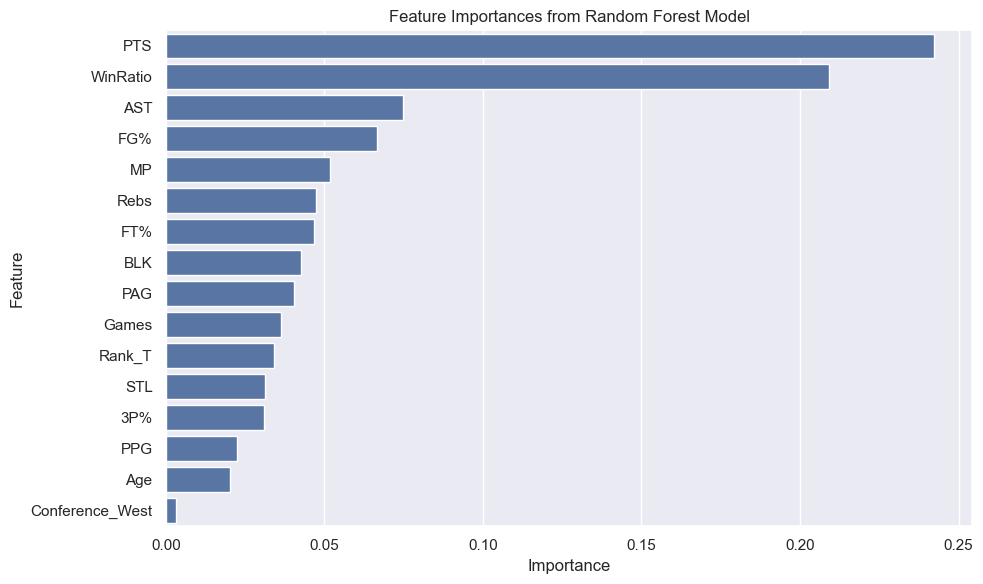

In [ ]:
best_model = grid_search.best_estimator_
rf_model = best_model.named_steps['regressor']
importances = rf_model.feature_importances_
feature_names = best_model.named_steps['prep'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': [name.replace("prep__", "").replace("cat__", "") for name in feature_names],
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

We can see that the player's points per game is the most important feature, closely followed by the team's winning ration. This indicates that the team's success is still a key factor in determining the MVP votes. 

Far behind, we find the other player's statistics, mainly the assists and field goal percentage. This indicates that the model is still able to capture the importance of the player's individual performance, but they are not as important as the team's success and the player's points per game.

It is also interisting to note that, contrary to what a lot of fans think, the conference of the team does not have a significant impact on the MVP votes.

### Predictions for the 2024-2025 Season

Let's now use our model to predict the MVP votes for the 2024-2025 season. We will use the same data preparation steps as before, and then use the trained model to predict the MVP votes for each player.

Here we are trying to show if the election of the MVP was made following the same criteria as the previous seasons, and if the model is able to predict the MVP votes for the 2024-2025 season. If the model is able to predict the MVP votes for the 2024-2025 season, it means that the election of the MVP was made following the same criteria as the previous seasons and it wasn't biased by the media or other factors.

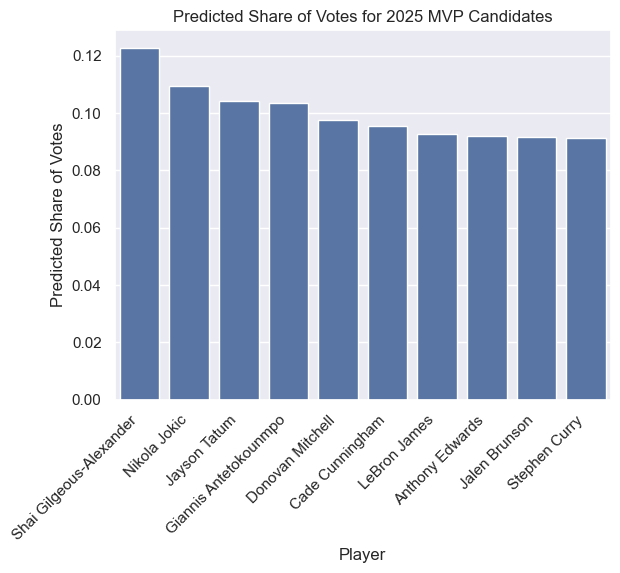

In [ ]:
df_2025 = df[df["Year"] == 2025].copy()
X_2025, _, _ = preprocess_df(df_2025, drop_cols)
df_2025["score"] = best_model.predict(X_2025) 
df_2025["predicted_share"] = df_2025.groupby("Year")["score"].transform(lambda x: softmax(x))
df_2025 = df_2025.sort_values("predicted_share", ascending=False)
ax = sns.barplot(df_2025, x="Player", y="predicted_share")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Predicted Share of Votes for 2025 MVP Candidates")
plt.ylabel("Predicted Share of Votes")
plt.show()